# Classification with ResNet Architecture in TensorFlow

Author: Diana Rogachova

Date: June 26, 2023

Course: Data Science Diploma Program

This notebook contains code for binary and multi-class classification using CNN model with ResNet50 architecture. In the first part of the notebook, I am focused on creating binary classification using only two classes of fruit. In the second part, I am repeating the same steps, with more than two fruit classes.

## Binary Classification

### Spliting Folders

Given my train data is in a single folder, I will need to split it into train and validation folder to further perform data augmentation only on one folder.

To learn how to split the folders, I used the following resource:

https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93  

In [1]:
# Instanling dependencies to split my train folder
!conda install splitfolders

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - splitfolders

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-arm64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-arm64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-arm64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://conda.anaconda.org/conda-forge/osx-arm64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [2]:
import splitfolders

splitfolders.ratio("Train Images Binary/Original", # train folder containing my two classes
                   output="Train images", # place when new subfolders will be created
                   seed=42,
                   ratio=(.8, .2), # spliting 80% for train and 20% for validation
                   group_prefix=None,
                   move=False
                   )

Copying files: 0 files [00:00, ? files/s]

Copying files: 956 files [00:00, 2436.66 files/s]


Now that the folder is split, I will perform data augmentation only on my train images, while also rescalling both sets.
The code to rescale images was taken both from lecture notes and partially from this resource:
https://www.youtube.com/watch?v=ccdssX4rIh8

### Data Preprocessing: Image Augmentation 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Selecting hight, width and indicating that these are collored images
height = 100
width = 100
channels = 3

train_datagen = ImageDataGenerator(rescale=1./255, # augmenting and rescaling train set
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='reflect')

validation_datagen = ImageDataGenerator(rescale=1./255) # only rescalling validation set

train_generator=train_datagen.flow_from_directory('Train Images Binary/train/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)

validation_generator=validation_datagen.flow_from_directory('Train Images Binary/val/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                               seed=123)

Found 764 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


The code above took the split folders I created earlier, scalled and augmented the train set as well as scaled the validation set. In total, I have **764** training images and **192** valiation images.  

In [4]:
# Importing random seed for reproducibility and importing layers for the model
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

def set_random_seed(seed):

    random.seed(seed)
    tf.random.set_seed(seed)

The architecture I am using for my classification task is ResNet 60 pre-trained model:
https://www.mathworks.com/help/deeplearning/ref/resnet50.html

ResNet50 is a CNN architecture that was trained on more than a million of ImageNet images. As the name suggests, ResNet50 is 50 convolutional layers deep. It can be used to on new image data for classification.  

### ResNet-50 

In [5]:
# Employing pre-trained ResNet50V2 model
from tensorflow.keras.applications import ResNet50V2

res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels)) # importing weights and freezing the top layer
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

In [6]:
# Freezing all layers to train only the layers I add
for layer in res_model.layers:
    layer.trainable = False

In [7]:
from tensorflow.keras.models import Model
set_random_seed(121)
resnet = res_model.output

resnet = Flatten()(resnet) # adding a flatten layer
resnet = Dense(32, activation='relu')(resnet) 
output = Dense(2, activation='softmax')(resnet) # the last layer is 2 because the task is binary classification

Source consulted to choose the last layer: https://stackoverflow.com/questions/50808593/difference-between-dense2-and-dense1-as-the-final-layer-of-a-binary-classifi

In [8]:
model = Model(inputs=res_model.input,
              outputs=output)

### Training the Model

Adding `f1score` to the model as another metric and to later use it for object detection tasks. 

The following code source: https://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr

In [9]:
import keras.backend as K

def f1_score(y_true, y_pred):

    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    precision = c1 / (c2 + K.epsilon())

    recall = c1 / (c3 + K.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

set_random_seed(121)
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

# Early stoping to stop the training when there is no improvement in loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)
model.fit(train_generator,
          epochs=20,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/20


2023-08-04 16:40:29.494604: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 8s 278ms/step - loss: 0.5605 - accuracy: 0.8613 - f1_score: 0.8620 - val_loss: 0.0332 - val_accuracy: 0.9844 - val_f1_score: 0.9844
Epoch 2/20
24/24 [==============================] - 6s 268ms/step - loss: 0.0378 - accuracy: 0.9882 - f1_score: 0.9881 - val_loss: 0.0058 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 3/20
24/24 [==============================] - 6s 268ms/step - loss: 0.0199 - accuracy: 0.9935 - f1_score: 0.9935 - val_loss: 8.2314e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 4/20
24/24 [==============================] - 6s 258ms/step - loss: 0.0097 - accuracy: 0.9961 - f1_score: 0.9961 - val_loss: 0.0081 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 5/20
24/24 [==============================] - 6s 257ms/step - loss: 0.0173 - accuracy: 0.9935 - f1_score: 0.9935 - val_loss: 0.0039 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 00005: early stopping


Only after several epochs the model is giving a very high accuracy on validation set. Next, it is time to test the model on the test set. I will import the test data the same way I loaded the train and validation sets with `ImageDataGenerator`. 

### Testing the Model

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255) # load and scale 
test_generator = test_datagen.flow_from_directory('Test Images Binary/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=322,
                                                  class_mode='categorical',
                                                  seed=123)

X_test, y_test = test_generator.next()

Found 322 images belonging to 2 classes.


In [12]:
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 2s 196ms/step - loss: 0.0159 - accuracy: 0.9969 - f1_score: 0.9972
Test loss: 0.015909718349575996
Test accuracy: 0.9968944191932678


The accuracy of the test set is comparable to that I observed on validation set and remains very high. Next, I will create a confusion matrix to evaluate the model probabilities (compiled probabilities showing how well the model classified/predicted each class). 

In [13]:
import numpy as np
# predictions
predict_probas = model.predict(X_test)

# Convering probabilities into label encoding
y_predict = np.argmax(predict_probas, axis=1)

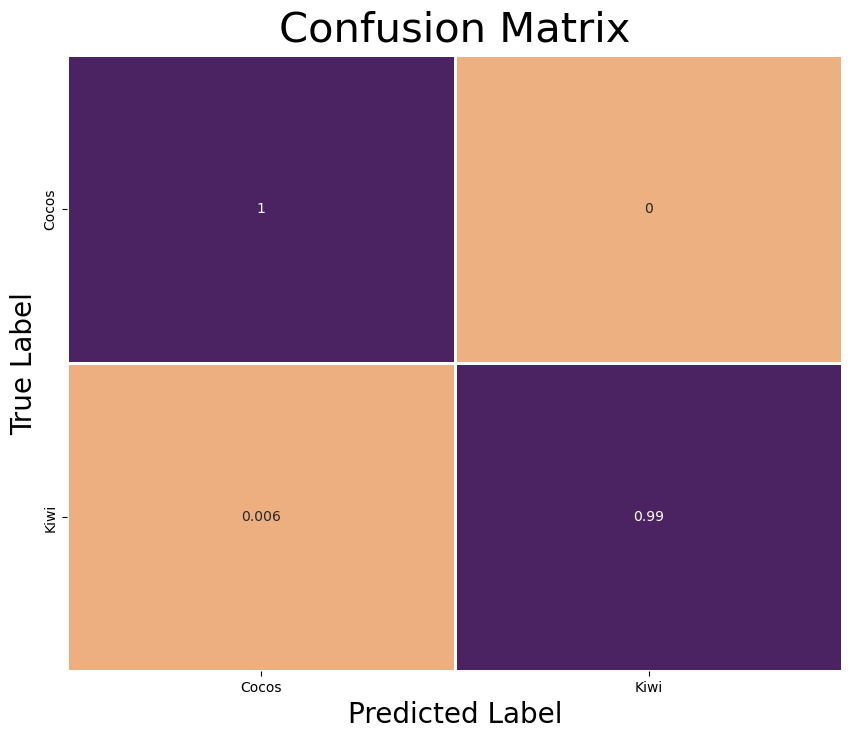

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fruit_labels = ['Cocos',
                'Kiwi']

y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (10,8))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=fruit_labels,
            yticklabels=fruit_labels,
            cmap="flare",
            linewidths=1,

           )
plt.title('Confusion Matrix',size = 30,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

The model gave almost perfect accuracy for the binary classification task. It appears that there was only one or a few instances where model misclassified the 'Kiwi' class. 

Next, I will repeat the exact steps but with multi-class classification task. 

I will repeat the same cells to ensure I am not forgetting any steps. 

## Multi-Class Classification

### Spliting files

In [15]:
import splitfolders

splitfolders.ratio("Train Images Multi/Original", # train folder containing the four classes
                   output="Train Images Multi", # place when new subfolders will be created
                   seed=42,
                   ratio=(.8, .2), # spliting 80% for train and 20% for validation
                   group_prefix=None,
                   move=False
                   )

Copying files: 2201 files [00:00, 2487.98 files/s]


### Data Preprocessing: Image Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Selecting hight, width and indicating that these are collored images
height = 100
width = 100
channels = 3

train_datagen = ImageDataGenerator(rescale=1./255, # augmenting and rescaling train set
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='reflect')

validation_datagen = ImageDataGenerator(rescale=1./255) # only rescalling validation set

train_generator=train_datagen.flow_from_directory('Train Images Multi/train/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 seed=123)

validation_generator=validation_datagen.flow_from_directory('Train Images Multi/val/', # source folder
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                               seed=123)

Found 1759 images belonging to 4 classes.
Found 442 images belonging to 4 classes.


### Adding Layers 

In [17]:
# Importing random seed for reproducibility and importing layers for the model
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

def set_random_seed(seed):

    random.seed(seed)
    tf.random.set_seed(seed)

### Resnet-50

In [18]:
# Employing pre-trained ResNet50V2 model
from tensorflow.keras.applications import ResNet50V2

res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels)) # importing weights and freezing the top layer
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

In [19]:
# freezing all layers to train only the layers I add
for layer in res_model.layers:
    layer.trainable = False

### Training the Model

In [20]:
from tensorflow.keras.models import Model
set_random_seed(121)
resnet = res_model.output

resnet = Flatten()(resnet)
resnet = Dense(32, activation='relu')(resnet)
output = Dense(4, activation='softmax')(resnet) # the last layer is 4 because the task is multi-class classification

In [21]:
model = Model(inputs=res_model.input,
              outputs=output)

In [22]:
import keras.backend as K

def f1_score(y_true, y_pred):

    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    if c3 == 0:
        return 0.0

    precision = c1 / (c2 + K.epsilon())

    recall = c1 / (c3 + K.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

set_random_seed(121)
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])


early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)
model.fit(train_generator,
          epochs=20,
          validation_data = validation_generator,
          callbacks=[early_stop])

Epoch 1/20
55/55 [==============================] - 15s 266ms/step - loss: 0.1865 - accuracy: 0.9329 - f1_score: 0.9332 - val_loss: 0.0349 - val_accuracy: 0.9819 - val_f1_score: 0.9821
Epoch 2/20
55/55 [==============================] - 14s 263ms/step - loss: 0.0137 - accuracy: 0.9920 - f1_score: 0.9920 - val_loss: 0.0020 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 3/20
55/55 [==============================] - 15s 269ms/step - loss: 0.0136 - accuracy: 0.9949 - f1_score: 0.9949 - val_loss: 0.0027 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 4/20
55/55 [==============================] - 15s 276ms/step - loss: 0.0063 - accuracy: 0.9972 - f1_score: 0.9972 - val_loss: 0.0053 - val_accuracy: 0.9977 - val_f1_score: 0.9978
Epoch 00004: early stopping


Similarly to the binary classification, the multi-class classification also showed a very high accuracy only after several epochs. 

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('Test Images Multi/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=734,
                                                  class_mode='categorical',
                                                  seed=123)

X_test2, y_test2 = test_generator.next()

Found 734 images belonging to 4 classes.


### Testing the Model

In [25]:
score = model.evaluate(X_test2, y_test2, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

23/23 [==============================] - 5s 208ms/step - loss: 0.0066 - accuracy: 0.9973 - f1_score: 0.9973
Test loss: 0.006561079993844032
Test accuracy: 0.9972752332687378


The test set demostrated similar accuracy to the test set in this classification task. Next, I will create a confusion matrix to see which the model's performance with different classes. 

In [26]:
import numpy as np
predict_probas2 = model.predict(X_test2)

y_predict2 = np.argmax(predict_probas2, axis=1)

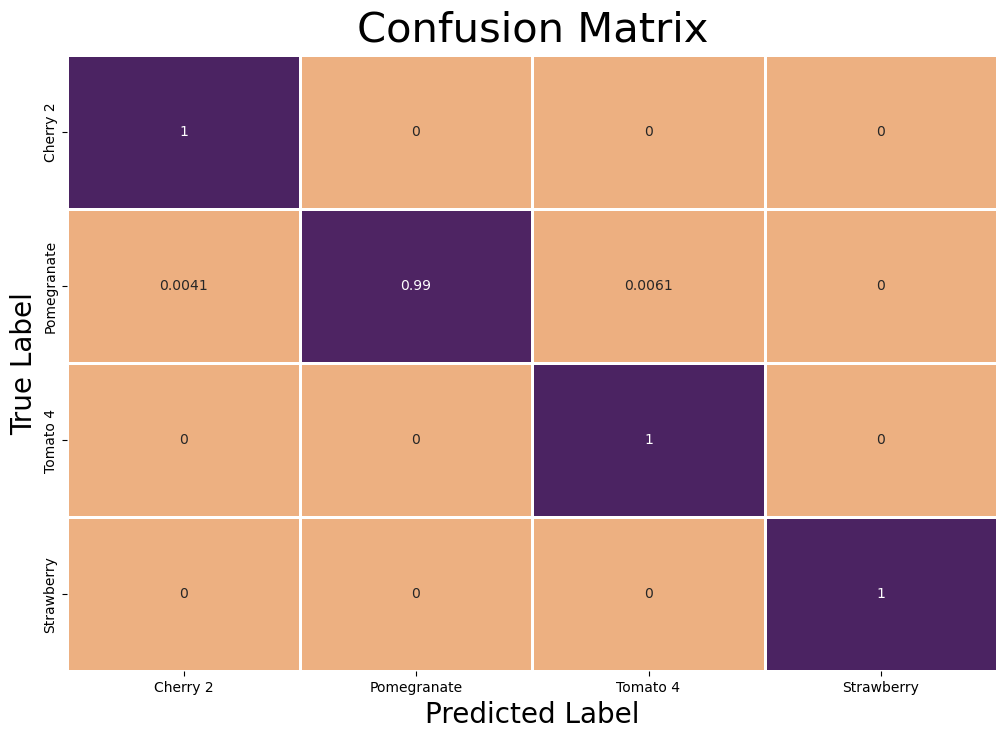

In [45]:
fruit2_labels = ['Cherry 2',
                'Pomegranate',
                'Tomato 4',
                'Strawberry']

y_test2_labels = np.argmax(y_test2, axis=1)

conf_mat = confusion_matrix(y_test2_labels, y_predict2)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (12,8))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=fruit2_labels,
            yticklabels=fruit2_labels,
            cmap="flare",
            linewidths=1,

           )
plt.title('Confusion Matrix',size = 30,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

## Conclusion

Convolutional Neural Networks (CNNs) are powerful tools that can be used for image classification with high accuracy. My experience showed that in comparison to base ML models such as Suport Vector Machines (SVM) or K-Nearest Neighbour (KNN), CNNs are performing slightly better in terms of accuracy with this particular dataset. The drawback of CNN is that they require more computational power and there are a few more steps involved before training a model.  